In [1]:
import pandas as pd
import numpy as np

In [2]:
#获得特征矩阵和标签矩阵
def get_Mat(path):
    dataSet = pd.read_table(path,header = None)
    xMat = np.mat(dataSet.iloc[:,:-1].values)
    yMat = np.mat(dataSet.iloc[:,-1].values).T
    return xMat,yMat

In [3]:
xMat,yMat = get_Mat('simpdata.txt')

In [4]:
xMat

matrix([[1. , 2.1],
        [1.5, 1.6],
        [1.3, 1. ],
        [1. , 1. ],
        [2. , 1. ]])

In [5]:
yMat

matrix([[ 1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]])

In [6]:
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['simhei']#显示中文
%matplotlib inline

In [8]:
#数据集可视化函数
def showPlot(xMat,yMat):
    x=np.array(xMat[:,0])
    y=np.array(xMat[:,1])
    label = np.array(yMat)
    plt.scatter(x,y,c=label)
    plt.title('单层决策树测试数据')
    plt.show()

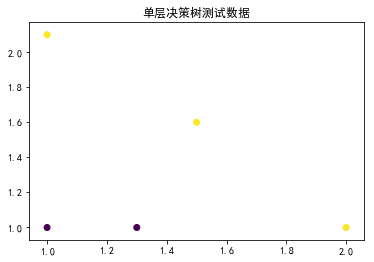

In [9]:
showPlot(xMat,yMat)

In [10]:
"""
函数功能：单层决策树分类函数
参数说明:
xMat: 数据矩阵
i: 第i列，也就是第几个特征
Q: 阈值
S: 标志
返回:
re: 分类结果
"""
def Classify0(xMat,i,Q,S):
    re = np.ones((xMat.shape[0],1)) #初始化re为1
    if S == 'lt':
        re[xMat[:,i] <= Q] = -1 #如果小于阈值,则赋值为-1
    else:
        re[xMat[:,i] > Q] = -1 #如果大于阈值,则赋值为-1
    return re

In [11]:
"""
函数功能：找到数据集上最佳的单层决策树
参数说明:
    xMat：特征矩阵
    yMat：标签矩阵
    D：样本权重
返回:
    bestStump：最佳单层决策树信息
    minE：最小误差
    bestClas：最佳的分类结果
"""
def get_Stump(xMat,yMat,D):
    m,n = xMat.shape #m为样本个数，n为特征数
    Steps = 10 #初始化一个步数
    bestStump = {} #用字典形式来储存树桩信息
    bestClas = np.mat(np.zeros((m,1))) #初始化分类结果为1
    minE = np.inf #最小误差初始化为正无穷大
    for i in range(n): #遍历所有特征
        Min = xMat[:,i].min() #找到特征中最小值
        Max = xMat[:,i].max() #找到特征中最大值
        stepSize = (Max - Min) / Steps #计算步长
        for j in range(-1, int(Steps)+1):
            for S in ['lt', 'gt']: #大于和小于的情况，均遍历。lt:less than，gt:greater than
                Q = (Min + j * stepSize) #计算阈值
                re = Classify0(xMat, i, Q, S) #计算分类结果
                err = np.mat(np.ones((m,1))) #初始化误差矩阵
                err[re == yMat] = 0 #分类正确的,赋值为0
                eca = D.T * err #计算误差
                #print(f'切分特征: {i}, 阈值:{np.round(Q,2)}, 标志:{S}, 权重误差:{np.round(eca,3)}')
                if eca < minE: #找到误差最小的分类方式
                    minE = eca
                    bestClas = re.copy()
                    bestStump['特征列'] = i
                    bestStump['阈值'] = Q
                    bestStump['标志'] = S
    return bestStump,minE,bestClas

In [12]:
m = xMat.shape[0]
D = np.mat(np.ones((m, 1)) / m) #初始化样本权重（每个样本权重相等）
get_Stump(xMat,yMat,D)

({'特征列': 0, '阈值': 1.3, '标志': 'lt'}, matrix([[0.2]]), array([[-1.],
        [ 1.],
        [-1.],
        [-1.],
        [ 1.]]))

In [15]:
np.sign(0)

0

In [16]:
"""
函数功能：基于单层决策树的AdaBoost训练过程
参数说明：
xMat：特征矩阵
yMat：标签矩阵
maxC：最大迭代次数
返回：
weakClass：弱分类器信息
aggClass：类别估计值（其实就是更改了标签的估计值）
"""
def Ada_train(xMat, yMat, maxC = 40):
    weakClass = []
    m = xMat.shape[0]
    D = np.mat(np.ones((m, 1)) / m) #初始化权重
    aggClass = np.mat(np.zeros((m,1)))
    for i in range(maxC):
        Stump, error, bestClas = get_Stump(xMat, yMat,D) #构建单层决策树
        #print(f"D:{D.T}")
        alpha=float(0.5 * np.log((1 - error) / max(error, 1e-16))) #计算弱分类器权重alpha
        Stump['alpha'] = np.round(alpha,2) #存储弱学习算法权重,保留两位小数
        weakClass.append(Stump) #存储单层决策树
        #print("bestClas: ", bestClas.T)
        expon = np.multiply(-1 * alpha *yMat, bestClas) #计算e的指数项
        D = np.multiply(D, np.exp(expon))
        D = D / D.sum() #根据样本权重公式，更新样本权重
        aggClass += alpha * bestClas #更新累计类别估计值
        #print(f"aggClass: {aggClass.T}" )
        aggErr = np.multiply(np.sign(aggClass) != yMat, np.ones((m,1)))#计算误差
        errRate = aggErr.sum() / m
        #print(f"分类错误率: {errRate}")
        if errRate == 0: break #误差为0，退出循环
    return weakClass, aggClass

In [17]:
weakClass, aggClass=Ada_train(xMat, yMat, maxC = 40)

In [18]:
weakClass

[{'特征列': 0, '阈值': 1.3, '标志': 'lt', 'alpha': 0.69},
 {'特征列': 1, '阈值': 1.0, '标志': 'lt', 'alpha': 0.97},
 {'特征列': 0, '阈值': 0.9, '标志': 'lt', 'alpha': 0.9}]

In [19]:
aggClass

matrix([[ 1.17568763],
        [ 2.56198199],
        [-0.77022252],
        [-0.77022252],
        [ 0.61607184]])

In [20]:
def AdaClassify(data,weakClass):
    dataMat = np.mat(data)
    m = dataMat.shape[0]
    aggClass = np.mat(np.zeros((m,1)))
    for i in range(len(weakClass)): #遍历所有分类器，进行分类
        classEst = Classify0(dataMat,
                             weakClass[i]['特征列'],
                             weakClass[i]['阈值'],
                             weakClass[i]['标志'])
        aggClass += weakClass[i]['alpha'] * classEst
        #print(aggClass)
    return np.sign(aggClass)

In [22]:
 AdaClassify([1.,2.1],weakClass)

matrix([[1.]])

In [23]:
train = pd.read_table('horseColicTraining2.txt',header=None)
test = pd.read_table('horseColicTest2.txt',header=None)

In [24]:
train.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,2.0,1.0,38.5,66.0,28.0,3.0,3.0,0.0,2.0,5.0,...,0.0,0.0,0.0,3.0,5.0,45.0,8.4,0.0,0.0,-1.0
1,1.0,1.0,39.2,88.0,20.0,0.0,0.0,4.0,1.0,3.0,...,0.0,0.0,0.0,4.0,2.0,50.0,85.0,2.0,2.0,-1.0
2,2.0,1.0,38.3,40.0,24.0,1.0,1.0,3.0,1.0,3.0,...,0.0,0.0,0.0,1.0,1.0,33.0,6.7,0.0,0.0,1.0
3,1.0,9.0,39.1,164.0,84.0,4.0,1.0,6.0,2.0,2.0,...,1.0,2.0,5.0,3.0,0.0,48.0,7.2,3.0,5.3,-1.0
4,2.0,1.0,37.3,104.0,35.0,0.0,0.0,6.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,74.0,7.4,0.0,0.0,-1.0


In [25]:
train.iloc[:,-1].value_counts()

 1.0    178
-1.0    121
Name: 21, dtype: int64

In [27]:
train.shape

(299, 22)

In [26]:
test.head()

,0,1,2,3,4,5,6,7,8,9,...,12,13,14,15,16,17,18,19,20,21
0,2.0,1.0,38.5,54.0,20.0,0.0,1.0,2.0,2.0,3.0,...,2.0,2.0,5.9,0.0,2.0,42.0,6.3,0.0,0.0,1.0
1,2.0,1.0,37.6,48.0,36.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,44.0,6.3,1.0,5.0,1.0
2,1.0,1.0,37.7,44.0,28.0,0.0,4.0,3.0,2.0,5.0,...,1.0,1.0,0.0,3.0,5.0,45.0,70.0,3.0,2.0,1.0
3,1.0,1.0,37.0,56.0,24.0,3.0,1.0,4.0,2.0,4.0,...,1.0,1.0,0.0,0.0,0.0,35.0,61.0,3.0,2.0,-1.0
4,2.0,1.0,38.0,42.0,12.0,3.0,0.0,3.0,1.0,1.0,...,0.0,0.0,0.0,0.0,2.0,37.0,5.8,0.0,0.0,1.0


In [28]:
def calAcc(maxC = 40):
    train_xMat,train_yMat = get_Mat('horseColicTraining2.txt')
    m=train_xMat.shape[0]
    weakClass, aggClass = Ada_train(train_xMat, train_yMat, maxC)
    yhat = AdaClassify(train_xMat,weakClass)
    train_re=0
    for i in range(m):
        if yhat[i]==train_yMat[i]:
            train_re+=1
    train_acc= train_re/m
    print(f'训练集准确率为{train_acc}')
    
    
    test_re=0
    test_xMat,test_yMat=get_Mat('horseColicTest2.txt')
    n=test_xMat.shape[0]
    yhat = AdaClassify(test_xMat,weakClass)
    for i in range(n):
        if yhat[i]==test_yMat[i]:
            test_re+=1
    test_acc=test_re/n
    print(f'测试集准确率为{test_acc}')
    return train_acc,test_acc


In [29]:
calAcc(maxC = 40)

训练集准确率为0.802675585284281
测试集准确率为0.8059701492537313


(0.802675585284281, 0.8059701492537313)

In [32]:
Cycles=[1,10,50,100,500,1000,10000]
train_acc=[]
test_acc=[]
for maxC in Cycles:
    a,b=calAcc(maxC)
    train_acc.append(round(a*100,2))
    test_acc.append(round(b*100,2))
df=pd.DataFrame({'分类器数目':Cycles,'训练集准确率':train_acc,'测试集准确率':test_acc})
df

训练集准确率为0.7157190635451505
测试集准确率为0.7313432835820896
训练集准确率为0.7658862876254181
测试集准确率为0.7611940298507462
训练集准确率为0.8093645484949833
测试集准确率为0.7910447761194029
训练集准确率为0.8093645484949833
测试集准确率为0.7761194029850746
训练集准确率为0.8394648829431438
测试集准确率为0.746268656716418
训练集准确率为0.8595317725752508
测试集准确率为0.7313432835820896
训练集准确率为0.8963210702341137
测试集准确率为0.6716417910447762


,分类器数目,训练集准确率,测试集准确率
0,1,71.57,73.13
1,10,76.59,76.12
2,50,80.94,79.10
3,100,80.94,77.61
4,500,83.95,74.63
5,1000,85.95,73.13
6,10000,89.63,67.16
